# Apartment for rent classified
This notebook contains the stages to execute an end-to-end process to obtain a regression model of apartment rent based on their characteristics.

## Setup

In [4]:
import os
import sys
import warnings
from typing import Tuple
from __future__ import annotations

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor

warnings.filterwarnings("ignore")

## Creating the classes

### Data Explorer

In [5]:
class DataExplorer:
    @staticmethod
    def explore_data(data: pd.DataFrame) -> None:
        print(data.head())
        print("\nDataset info")
        print(data.info())
        num_cols = data.select_dtypes(include=[np.number]).columns.tolist()
        print(f'Numerical columns ({len(num_cols)}): {num_cols}')
        cat_cols = data.select_dtypes(include=['object']).columns.tolist()
        print(f'Categorical columns ({len(cat_cols)}): {cat_cols}')
        print("\nDataset numerical description")
        print(data.describe().T)
        print("\nDataset categorical description")
        print(data.describe(include=['object']).T)
        print("\nMissing values %")
        print(data.isna().mean()*100)
    
    @staticmethod
    def plot_hist(data: pd.DataFrame) -> None:
        data.hist(bins=20, figsize=(20, 10))
        plt.suptitle("Histograms of numerical columns", fontsize=20)
        plt.show()

    @staticmethod
    def plot_bar(data: pd.DataFrame) -> None:
        obj_cols = data.select_dtypes(include=['object']).columns
        fig, axes = plt.subplots(7, 2, figsize=(12, 22))
        axes = axes.flatten()
        for ax, col in zip(axes, obj_cols):
            if data[col].nunique() < 50:
                data[col].value_counts().plot(kind='bar', ax=ax, title=col)
                ax.tick_params(axis='x', labelrotation = 50)
            else:
                ax.text(0.5, 0.5, f"'{col}' has {data[col].nunique()} unique values", horizontalalignment='center', verticalalignment='center')
                ax.tick_params(left = False, right = False, labelleft = False, labelbottom = False, bottom = False) 
        plt.suptitle("Bar plots of categorical columns", fontsize=20)
        plt.tight_layout()
        plt.show()

    @staticmethod
    def plot_corr(data: pd.DataFrame) -> None:
        plt.figure(figsize=(12, 8))
        sns.heatmap(data.corr(), annot=True, cmap='coolwarm', fmt=".2f", center=0, square=True, linewidths=.5)
        plt.title("Correlation matrix")
        plt.show()

### Apartment price model

In [64]:
class ApartmentPriceModel:
    def __init__(self, filepath: str) -> None:
        self.filepath = filepath
        self.data = None
        self.model = None

    def load_data(self) -> ApartmentPriceModel:
        self.data = pd.DataFrame()
        for file in os.listdir(self.filepath):
            if file.endswith(".csv"):
                parcial_data = pd.read_csv(os.path.join(self.filepath, file), sep=";", encoding='cp1252')
                self.data = pd.concat([self.data, parcial_data], axis=0)
            print(f"Shape of the {file} is: {parcial_data.shape}")
        return self
    
    @staticmethod
    def __drop_duplicates(data: pd.DataFrame) -> pd.DataFrame:
        data.drop_duplicates(inplace=True)
        return data

    @staticmethod
    def __fill_missing_values(data: pd.DataFrame) -> pd.DataFrame:
        # fill missing values with median
        for col in ['bathrooms', 'bedrooms', 'latitude', 'longitude']:
            data[col].fillna(data[col].median(), inplace=True)

        # fill missing values with new category
        data['pets_allowed'].fillna('unknown', inplace=True)
        return data

    @staticmethod
    def __drop_columns(data: pd.DataFrame) -> pd.DataFrame:
        # unnecessary columns
        data.drop(columns =["id", "title", "body", "time", "price_display"], inplace=True)
        # constant columns
        data.drop(columns=["category", "currency", "fee", "price_type"], inplace=True)
        # high cardinality columns
        data.drop(columns=["amenities", "address", "cityname", "state", "source"], inplace=True)
        return data

    @staticmethod
    def __remove_nans(data: pd.DataFrame) -> pd.DataFrame:
        # Remove rows with missing target
        data.dropna(subset=["price"], inplace=True)
        # Remove no bedrooms
        data = data[data["bedrooms"] > 0]
        return data

    @staticmethod
    def __encode_categorical(data: pd.DataFrame) -> pd.DataFrame:
        categorical_columns = data.select_dtypes(include=['object']).columns.tolist()
        data = pd.get_dummies(data, columns=categorical_columns, drop_first=True)
        return data
    
    def preprocess_data(self) -> ApartmentPriceModel:
        # Drop duplicates
        self.data = self.__drop_duplicates(self.data)
        # Fill missing values
        self.data = self.__fill_missing_values(self.data)
        # Drop columns
        self.data = self.__drop_columns(self.data)
        # Remove nans
        self.data = self.__remove_nans(self.data)
        # Encode categorical columns
        self.data = self.__encode_categorical(self.data)
        self.data.to_csv("..\data\interim\preprocessed_data.csv", index=False)
        return self

    @staticmethod
    def __scale_features(X_train: pd.DataFrame, X_test: pd.DataFrame) -> Tuple[pd.DataFrame, pd.DataFrame]:
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
        X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)
        return X_train_scaled, X_test_scaled

    def split_data(self) -> ApartmentPriceModel:
        X = self.data.drop(columns=["price"])
        y = self.data["price"]
        y = np.log(y)
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        self.X_train, self.X_test = self.__scale_features(self.X_train, self.X_test)
        self.X_train.to_csv("..\data\processed\X_train.csv", index=False)
        self.X_test.to_csv("..\data\processed\X_test.csv", index=False)
        self.y_train.to_csv("..\data\processed\y_train.csv", index=False)
        self.y_test.to_csv("..\data\processed\y_test.csv", index=False)
        return self
    
    def train_model(self) -> ApartmentPriceModel:
        self.model = XGBRegressor()
        self.model.fit(self.X_train, self.y_train)
        print("Model trained")
        return self
    
    @staticmethod
    def __plot_regression(y_test: pd.Series, y_pred: np.ndarray, rmse: float, mse: float, r2: float) -> None:
        plt.figure(figsize=(12, 8))
        sns.scatterplot(x=y_test, y=y_pred)
        min_val = min(y_test.min(), y_pred.min())
        max_val = max(y_test.max(), y_pred.max())
        plt.plot([min_val, max_val], [min_val, max_val], 'r--')
        plt.xlabel("Actual price")
        plt.ylabel("Predicted price")
        plt.title("Actual vs Predicted price (scaled)")
        plt.text(min_val, max_val, f"RMSE: {rmse:.4f}", va='top')
        plt.text(min_val, max_val-(max_val/24), f"MSE: {mse:.4f}", va='top')
        plt.text(min_val, max_val-(max_val/12), f"R2: {r2:.4f}", va='top')
        plt.show()

    @staticmethod
    def __plot_feature_importance(model: XGBRegressor, X: pd.DataFrame) -> None:
        features = X.columns
        importances = model.feature_importances_
        ax = plt.axes()
        indices = np.argsort(importances)
        plt.barh(range(len(indices)), importances[indices], color='blue', align='center')
        plt.yticks(range(len(indices)), [features[i] for i in indices])
        plt.title('Feature importance')
        plt.show()

    def evaluate_model(self) -> ApartmentPriceModel:
        y_pred = self.model.predict(self.X_test)
        mse = mean_squared_error(self.y_test, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(self.y_test, y_pred)
        print(f"RMSE: {rmse:.4f}")
        print(f"MSE: {mse:.4f}")
        print(f"R2: {r2:.4f}")
        self.__plot_regression(self.y_test, y_pred, rmse, mse, r2)
        self.__plot_feature_importance(self.model, self.X_test)
        return self

### Executing the code

Shape of the apartments_for_rent_classified_100K.csv is: (99492, 22)
Shape of the apartments_for_rent_classified_10K.csv is: (10000, 22)
Model trained
RMSE: 0.1900
MSE: 0.0361
R2: 0.8138


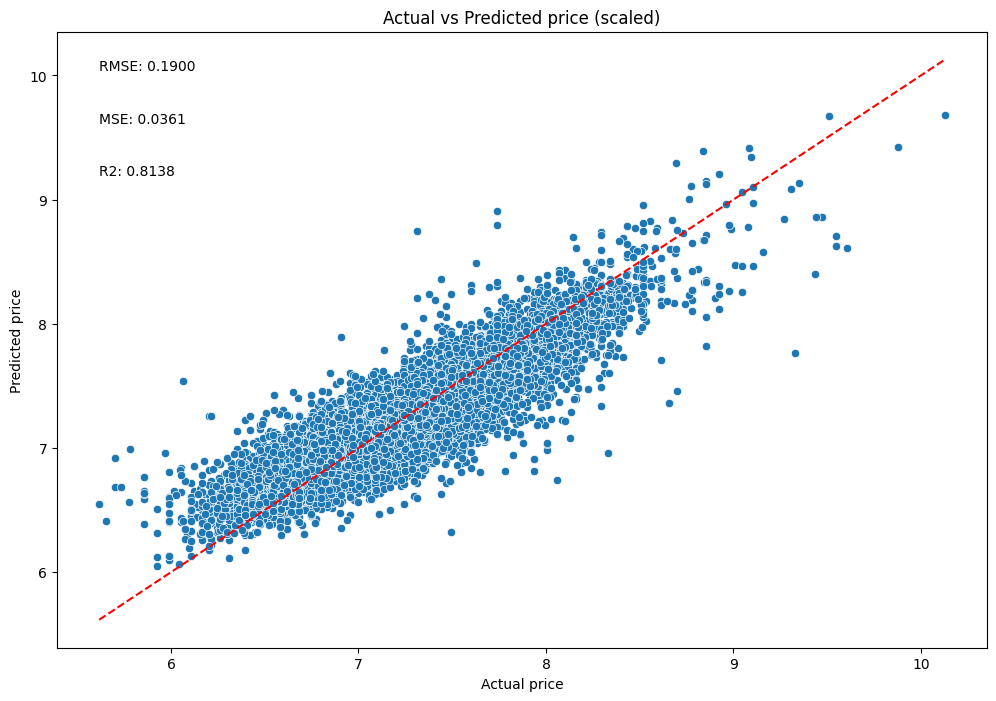

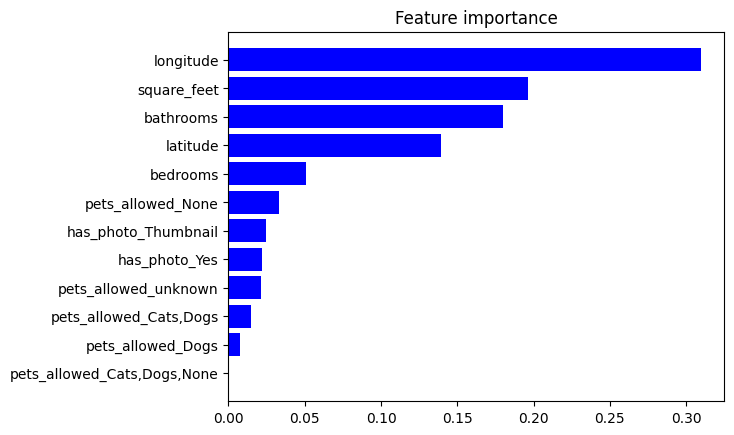

In [65]:
filepath = r"..\data\raw"

model = ApartmentPriceModel(filepath)
model.load_data()
model.preprocess_data()
model.split_data()
model.train_model()
model.evaluate_model()